In [1]:
import os
os.chdir('..')
os.chdir('..')
import torch
from data_loader import Dataset_AffectNet_image
import torchvision
from torchvision.models import resnet50, ResNet50_Weights,resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
from utils import data_augm,data_adapt
import torch
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

affectNet_img = '/home/ens/AT91140/project_DA/Datasets/AffectNet/Manually_Annotated_Images'
affectNet_annot_train = '/home/ens/AT91140/project_DA/Datasets/AffectNet/training_wo_landmark.csv'
affectNet_annot_val = '/home/ens/AT91140/project_DA/Datasets/AffectNet/validation_wo_landmark.csv'


save_path =  '/home/ens/AT91140/project_DA/models/'

In [2]:
device_ids = [1]
for d in device_ids:
    torch.cuda.set_device(d)
    torch.cuda.empty_cache()
    #torch.cuda.current_device()
    torch.cuda.get_device_name()
device = f'cuda:{device_ids[0]}'

In [3]:
EPOCH = 100
BATCH_SIZE = 100
EARLY_STOPPING = 100
LEARNING_RATE = 0.0001
RESOLUTION = 224
nb_class = 7

load_name = 'Resnet50_224_8_class.pt'
save_model_name = 'Resnet50_224_8_class.pt'

tr = data_augm(RESOLUTION)
tr_test = data_adapt(RESOLUTION)
tr_size = torchvision.transforms.Resize((RESOLUTION,RESOLUTION),antialias=True)

In [4]:
dataset_train = Dataset_AffectNet_image(affectNet_img, affectNet_annot_train,
                                    tr.transform,crop=True,nb_image=None,
                                    type_output='expression',balanced=True,nb_class=nb_class)



loader_train = torch.utils.data.DataLoader(dataset_train,
                                             batch_size=BATCH_SIZE, shuffle=True,
                                             num_workers=0,drop_last = True)

dataset_test = Dataset_AffectNet_image(affectNet_img, affectNet_annot_val,tr_test.transform,crop=True,type_output='expression',balanced=False,nb_class=nb_class)




loader_test = torch.utils.data.DataLoader(dataset_test,
                                             batch_size=BATCH_SIZE, shuffle=True,
                                             num_workers=0)


In [5]:
loss_t = torch.nn.CrossEntropyLoss(reduction='sum')

In [6]:
class ResNet(torch.nn.Module):
    def __init__(self,nb_class,model=resnet50,weights=ResNet50_Weights.IMAGENET1K_V2):
        super(ResNet,self).__init__()

        self.resnet_model = model(weights=weights)
        self.fc1 = torch.nn.Linear(1000,100)
        self.fc2 = torch.nn.Linear(100,nb_class)


    def forward(self,x):
        x = self.resnet_model(x)
        x = self.fc1(x).relu()
        x = self.fc2(x).softmax(dim=-1)
        return x

In [7]:
model = ResNet(nb_class,resnet18,ResNet18_Weights.IMAGENET1K_V1).to(device)
#model = torch.nn.DataParallel(model, device_ids=device_ids)
#model.load_state_dict(torch.load(save_path+load_name))

In [8]:
optimizer = torch.optim.Adam(list(model.parameters()),lr=LEARNING_RATE)

In [12]:
min_loss_val = None
dic_log = {'loss_CE_train':[],'loss_CE_val':[],'loss_acc_train':[],'loss_acc_val':[]}
count = 0 
for epoch in range(EPOCH):
    dataset_train.reset()
    loss_task_tot = 0
    elem_sum = 0
    true_response = 0
    model.train()
    loop_train = tqdm(loader_train,colour='BLUE')
    for i,pack in enumerate(loop_train):

        img_tensor = pack[0].to(device)
        target_tensor = pack[1].to(device)

        # TASK 1
        output = model(img_tensor)
        loss_task = loss_t(output,target_tensor) 
        true_response += float(torch.sum(output.max(dim=-1)[1] == target_tensor))
        loss = loss_task 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        elem_sum += img_tensor.shape[0]
        loss_task_tot += float(loss_task)

        loop_train.set_description(f"Epoch [{epoch}/{EPOCH}] training")
        loop_train.set_postfix(loss_task = loss_task_tot/elem_sum,accuracy=true_response/elem_sum*100,
                                loading = str(round(len(dataset_train.dic_image)/dataset_train.img_loaded.shape[0]*100,2))+'%')
    
    model.eval()
    loss_task_val = 0
    elem_sum_val = 0
    true_response_val  =0
    loop_test = tqdm(loader_test,colour='GREEN')
    for pack in loop_test:
            img_tensor = pack[0].to(device)
            target_tensor = pack[1].to(device)
            
            with torch.no_grad():
                output = model(img_tensor)

            loss_task = loss_t(output,target_tensor)
            loss = loss_task
            result = output.max(dim=-1)[1]
            true_response_val += float(torch.sum(result == target_tensor))
            elem_sum_val += img_tensor.shape[0]
            loss_task_val += float(loss_task)
            loop_test.set_description(f"Test count {count}")
            loop_test.set_postfix(loss_task = loss_task_val/elem_sum_val,accuracy=true_response_val/elem_sum_val*100,
                                    loading = str(round(len(dataset_test.dic_image)/dataset_test.img_loaded.shape[0]*100,2))+'%')
    
    dic_log['loss_CE_train'].append(loss_task_tot/elem_sum)
    dic_log['loss_acc_train'].append(true_response/elem_sum*100)
    dic_log['loss_CE_val'].append(loss_task_val/elem_sum_val)
    dic_log['loss_acc_val'].append(true_response_val/elem_sum_val*100)
    
    if min_loss_val is None or min_loss_val > loss_task_val/elem_sum_val:
        count = 0
        torch.save(model.state_dict(),save_path+save_model_name)
        min_loss_val = loss_task_val/elem_sum_val
    else:
        count +=1
        if count >= EARLY_STOPPING:
            break



Epoch [0/100] training:  51%|█████     | 136/266 [03:02<02:38,  1.22s/it, accuracy=58.5, loading=25.1%, loss_task=1.58] 

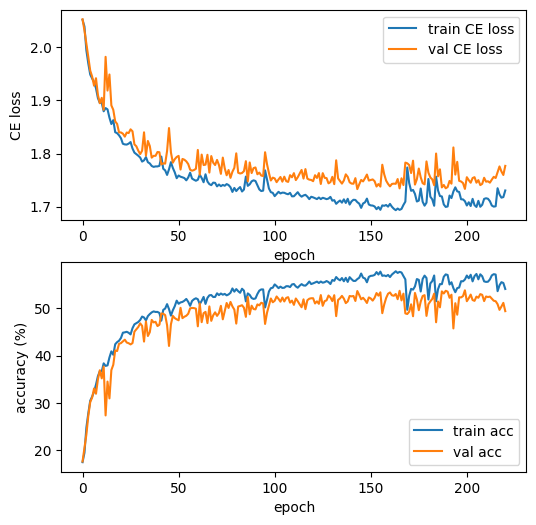

In [ ]:
import pandas as pd
dataframe = pd.DataFrame(dic_log)
fig, axs = plt.subplots(2,1,figsize = (6,6))
axs = axs.flat
axs[0].plot(dic_log['loss_CE_train'],label='train CE loss')
axs[0].plot(dic_log['loss_CE_val'],label='val CE loss')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('CE loss')
axs[0].legend()
axs[1].plot(dic_log['loss_acc_train'],label='train acc')
axs[1].plot(dic_log['loss_acc_val'],label='val acc')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy (%)')
axs[1].legend()

In [ ]:
model.eval()
M = torch.zeros((nb_class,nb_class))
acc_tot = 0
loss_tot = 0
loss_task_tot = 0
elem_sum = 0
true_response  =0
loop_test = tqdm(loader_test,colour='GREEN')
for pack in loop_test:
        img_tensor = pack[0].to(device)
        target_tensor = pack[1].to(device)
        
        with torch.no_grad():
            output = model(img_tensor)

        loss_task = loss_t(output,target_tensor)
        loss = loss_task
        result = output.max(dim=-1)[1]
        true_response += float(torch.sum(result == target_tensor))
        for i in range(target_tensor.shape[0]):
                M[int(target_tensor[i]),int(result[i])] +=1
        elem_sum += img_tensor.shape[0]
        loss_task_tot += float(loss_task)
        loop_test.set_description(f"Test")
        loop_test.set_postfix(loss_task = loss_task_tot/elem_sum,accuracy=true_response/elem_sum*100)
accuracy = true_response/elem_sum*100

  0%|          | 0/40 [00:00<?, ?it/s]

Test: 100%|██████████| 40/40 [00:34<00:00,  1.16it/s, accuracy=53.7, loss_task=1.73]


Text(0.5, 1.0, 'Test confusion matrix')

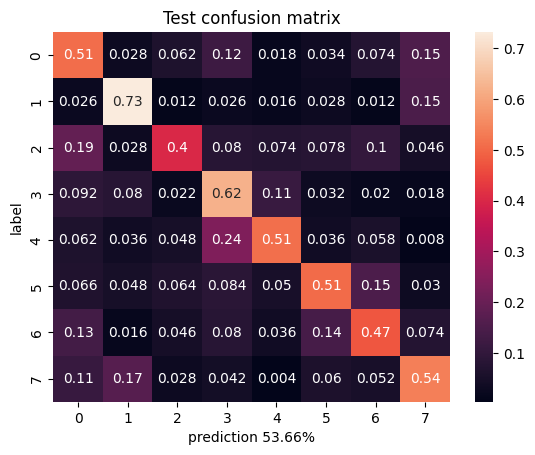

In [ ]:
import seaborn as sns
sns.heatmap(M/500,annot=True)
plt.xlabel(f'prediction {round(accuracy,2)}%')
plt.ylabel('label')
plt.title('Test confusion matrix')

In [ ]:
from torchsummary import summary
summary(model,(3,112,112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           9,408
       BatchNorm2d-2           [-1, 64, 56, 56]             128
              ReLU-3           [-1, 64, 56, 56]               0
         MaxPool2d-4           [-1, 64, 28, 28]               0
            Conv2d-5           [-1, 64, 28, 28]           4,096
       BatchNorm2d-6           [-1, 64, 28, 28]             128
              ReLU-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]          36,864
       BatchNorm2d-9           [-1, 64, 28, 28]             128
             ReLU-10           [-1, 64, 28, 28]               0
           Conv2d-11          [-1, 256, 28, 28]          16,384
      BatchNorm2d-12          [-1, 256, 28, 28]             512
           Conv2d-13          [-1, 256, 28, 28]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
model.module.resnet_model._modules.keys()

odict_keys(['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc'])

In [ ]:
new_res = torch.nn.Sequential(*list(resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).children())[:8]).to(device)
summary(new_res,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
summary(new_res,(3,112,112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           9,408
       BatchNorm2d-2           [-1, 64, 56, 56]             128
              ReLU-3           [-1, 64, 56, 56]               0
         MaxPool2d-4           [-1, 64, 28, 28]               0
            Conv2d-5           [-1, 64, 28, 28]           4,096
       BatchNorm2d-6           [-1, 64, 28, 28]             128
              ReLU-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]          36,864
       BatchNorm2d-9           [-1, 64, 28, 28]             128
             ReLU-10           [-1, 64, 28, 28]               0
           Conv2d-11          [-1, 256, 28, 28]          16,384
      BatchNorm2d-12          [-1, 256, 28, 28]             512
           Conv2d-13          [-1, 256, 28, 28]          16,384
      BatchNorm2d-14          [-1, 256,